In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

<h1> Prepare data </h1>

<h5> Load Excel file as dataframes </h5>

In [184]:
invoices = pd.read_excel('sales_original.xlsx', sheet_name = 'invoices')
assessment = pd.read_excel('sales_original.xlsx', sheet_name = 'assessment')
customers = pd.read_excel('sales_original.xlsx', sheet_name = 'customers')
products = pd.read_excel('sales_original.xlsx', sheet_name = 'products')
stock = pd.read_excel('sales_original.xlsx', sheet_name = 'stock')

KeyboardInterrupt: 

We cleaned the individual dataframes for our SQL queries. <br>
But for the EDA, we want to use all of the data. Sometimes the dropped duplicate rows or null values may still hold important information. <br>

The way these dataframes were created was: each row in each excel spread corresponds to the same row in all the other spreads. <br>
So we will concatenate along the row axis.


In [185]:
merged_table = pd.concat([invoices, assessment, customers, products, stock], axis = 1)

In [186]:
merged_table.head(2)

,InvoiceNo,ASIN,Quantity,price,total_sale,invoice_date,invoice_time,CustomerID,rating,review_count,ASIN,CustomerID,Country,ASIN,title,product_type,StockCode,ASIN
0,78536597,B07GWKDLGT,4,496.95,1987.80,2018-12-01,17,18011,4.6,1399,B07GWKDLGT,18011,Germany,B07GWKDLGT,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,B07GWKDLGT
1,78536597,B01MTLH408,4,39.99,159.96,2018-12-01,17,18011,4.6,289,B01MTLH408,18011,Germany,B01MTLH408,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,B01MTLH408


In [187]:
merged_table.columns

Index(['InvoiceNo', 'ASIN', 'Quantity', 'price', 'total_sale', 'invoice_date',
       'invoice_time', 'CustomerID', 'rating', 'review_count', 'ASIN',
       'CustomerID', 'Country', 'ASIN', 'title', 'product_type', 'StockCode',
       'ASIN'],
      dtype='object')

Drop duplicate columns

In [188]:
merged_table.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False,  True])

In [189]:
merged_table = merged_table.loc[:, ~merged_table.columns.duplicated()]

In [190]:
merged_table.head(2)

,InvoiceNo,ASIN,Quantity,price,total_sale,invoice_date,invoice_time,CustomerID,rating,review_count,Country,title,product_type,StockCode
0,78536597,B07GWKDLGT,4,496.95,1987.80,2018-12-01,17,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703
1,78536597,B01MTLH408,4,39.99,159.96,2018-12-01,17,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001


Relabel columns 

In [191]:
merged_table = merged_table.rename(columns = {'InvoiceNo': 'invoice_no', 'ASIN':'product_id', 'Quantity': 'quantity', 'price': 'unit_price', 
                                'CustomerID': 'customer_id', 'Country': 'country', 'title':'product_name', 'StockCode': 'stock_code'})

Combine "invoice_date" + "invoice_time" as "invoice_datetime"

In [192]:
merged_table['invoice_datetime'] = merged_table['invoice_date'] + merged_table['invoice_time'].astype('timedelta64[h]')
merged_table = merged_table.drop(['invoice_date', 'invoice_time'], axis = 1)

In [193]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00


In [284]:
# Add "day_of_week" column
merged_table['day_of_week'] = merged_table['invoice_datetime'].dt.dayofweek # 0 = Monday, 1 = Tuesday, etc.

# Add "month" column
merged_table['month'] = merged_table['invoice_datetime'].dt.month

# Add "hour" column
merged_table['hour'] = merged_table['invoice_datetime'].dt.hour

# Add "year" column
merged_table['year'] = merged_table['invoice_datetime'].dt.year

# Add "quarter" column
merged_table['quarter'] = merged_table['invoice_datetime'].dt.quarter


In [141]:
merged_table['invoice_date'] = merged_table['invoice_datetime'].dt.date

Save the dataframe as csv

In [143]:
merged_table.to_csv('merged_table', index = False)

<h3> EDA </h3>

In [4]:
merged_table = pd.read_csv('merged_table', parse_dates = ['invoice_datetime'])

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The dataframe contains data from Dec 2018 until Dec 2019. <br>
Since we will be studying monthly and quarterly trends too, we need to be studying complete years. <br>
So, for the following analysis, we will work only with the 2019 data.

In [5]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4


<h3> Customer buying pattern </h3>

Number of unique purchases vs day_of_week, month, hour of day

In [6]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4


In [7]:
# Get unique invoice numbers and invoice datetime.
# Only select the year 2019

unique_invoices = merged_table[merged_table['year'] == 2019].groupby(['invoice_no', 'day_of_week', 'month','hour', 'quarter']).count().reset_index().iloc[:,:5]

In [8]:
unique_invoices.head()

,invoice_no,day_of_week,month,hour,quarter
0,78539993,4,1,10,1
1,78540001,4,1,10,1
2,78540002,4,1,10,1
3,78540003,4,1,10,1
4,78540004,4,1,10,1


In [9]:
unique_invoices_dow = unique_invoices.groupby(['day_of_week'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('day_of_week')
unique_invoices_month = unique_invoices.groupby(['month'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('month')
unique_invoices_hour = unique_invoices.groupby(['hour'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('hour')
unique_invoices_quarter = unique_invoices.groupby(['quarter'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('quarter')

Strangely, there appear to have been no orders on Tuesday (day_of_week = 1). <br>
Add that missing column 

In [10]:
unique_invoices_dow = unique_invoices_dow.reset_index()
unique_invoices_dow

,day_of_week,num_orders
0,0,3047
1,2,2052
2,3,2993
3,4,3430
4,5,3566
5,6,3964


In [11]:
new_row = pd.DataFrame({'day_of_week': [1],  'num_orders':[0]})
unique_invoices_dow = pd.concat([unique_invoices_dow, new_row], axis = 0).sort_values(['day_of_week'])

In [12]:
unique_invoices_dow.index = [0,1,2,3,4,5,6]

In [13]:
unique_invoices_dow

,day_of_week,num_orders
0,0,3047
1,1,0
2,2,2052
3,3,2993
4,4,3430
5,5,3566
6,6,3964


In [14]:
unique_invoices_month.reset_index (inplace=True)

In [15]:
unique_invoices_month

,month,num_orders
0,1,1100
1,2,1108
2,3,1496
3,4,1277
4,5,1707
5,6,1588
6,7,1497
7,8,1451
8,9,1884
9,10,2154


In [16]:
unique_invoices_hour = unique_invoices_hour.sort_index().reset_index()
unique_invoices_hour

,hour,num_orders
0,6,1
1,7,27
2,8,542
3,9,1412
4,10,2252
5,11,2304
6,12,3074
7,13,2602
8,14,2349
9,15,2185


In [17]:
unique_invoices_quarter = unique_invoices_quarter.reset_index()

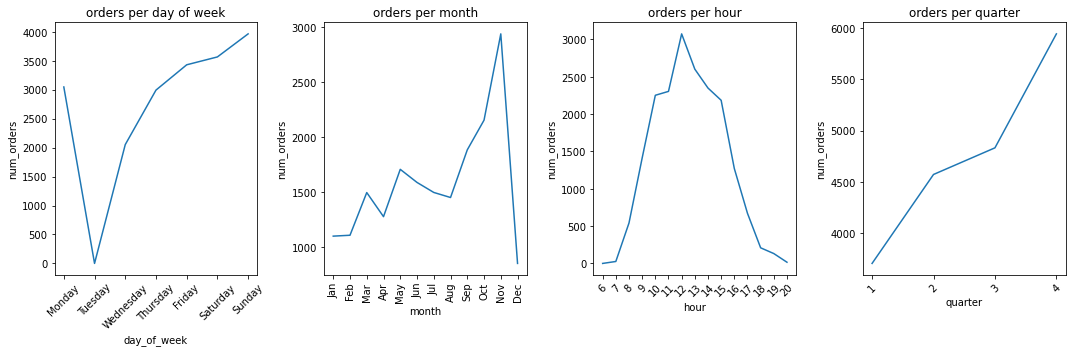

In [18]:
fig, ax = plt.subplots(1,4, figsize = (15,5))
ax_0 = sns.lineplot(ax = ax[0], data = unique_invoices_dow, x = 'day_of_week', y = 'num_orders')
ax_0.set_xticks(range(len(unique_invoices_dow['day_of_week'])))
ax_0.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'], rotation = 45)
ax_0.set_title('orders per day of week')
ax_1 = sns.lineplot(ax = ax[1], data = unique_invoices_month, x = 'month', y = 'num_orders')
ax_1.set_xticks(range(1, len(unique_invoices_month.index)+1))
ax_1.set_xticklabels(['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation = 90)
ax_1.set_title('orders per month')
ax_2 = sns.lineplot(ax = ax[2], data = unique_invoices_hour, x = 'hour', y = 'num_orders')
ax_2.set_xticks(range(6, len(unique_invoices_hour.index)+6))
ax_2.set_xticklabels(range(6, len(unique_invoices_hour.index)+6), rotation = 45)
ax_2.set_title('orders per hour')
ax_3 = sns.lineplot(ax = ax[3], data = unique_invoices_quarter, x = 'quarter', y = 'num_orders')
ax_3.set_xticks(range(1, len(unique_invoices_quarter['quarter'])+1))
ax_3.set_xticklabels(range(1, len(unique_invoices_quarter['quarter'])+1), rotation = 45)
ax_3.set_title('orders per quarter')


plt.tight_layout()
plt.show()

Note that in the graph for "orders per month", the num_orders drops suddenly in December. <br>
This is only because the 2019 data only goes up to 9 Dec. 

<h3> Some More Aggregation dataframes </h3>

Group by: 

day_of_week <br>
hour  <br>
month <br>
country


In [144]:
# Group by day of week
df_dow = merged_table.groupby(['day_of_week']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})

df_dow['num_orders']=df_dow['invoice_no']['nunique']
df_dow['total_sale_mean']=df_dow['total_sale']['mean']
df_dow['total_revenue']=df_dow['total_sale']['sum']
df_dow['num_unique_customers']= df_dow['customer_id']['nunique']
df_dow['units_sold_mean'] = df_dow['quantity']['mean']
df_dow['total_units_sold'] = df_dow['quantity']['sum']

df_dow = df_dow[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_dow = df_dow.reset_index()

df_dow.loc['6'] = [1,0,0,0,0]
df_dow = df_dow.sort_values('day_of_week')
df_dow.index = [0,1,2,3,4,5,6]


# Group by hour
df_hour = merged_table.groupby(['hour']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_hour['num_orders']=df_hour['invoice_no']['nunique']
df_hour['total_sale_mean']=df_hour['total_sale']['mean']
df_hour['total_revenue']=df_hour['total_sale']['sum']
df_hour['num_unique_customers']= df_hour['customer_id']['nunique']
df_hour['units_sold_mean'] = df_hour['quantity']['mean']
df_hour['total_units_sold'] = df_hour['quantity']['sum']

df_hour = df_hour[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_hour = df_hour.reset_index()


# Group by month
df_month = merged_table.groupby(['month']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_month['num_orders']=df_month['invoice_no']['nunique']
df_month['total_sale_mean']=df_month['total_sale']['mean']
df_month['total_revenue']=df_month['total_sale']['sum']
df_month['num_unique_customers']= df_month['customer_id']['nunique']
df_month['units_sold_mean'] = df_month['quantity']['mean']
df_month['total_units_sold'] = df_month['quantity']['sum']

df_month = df_month[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_month = df_month.reset_index()

# Group by invoice_date
df_date = merged_table.groupby(['invoice_date']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_date['num_orders']=df_date['invoice_no']['nunique']
df_date['total_sale_mean']=df_date['total_sale']['mean']
df_date['total_revenue']=df_date['total_sale']['sum']
df_date['num_unique_customers']= df_date['customer_id']['nunique']
df_date['units_sold_mean'] = df_date['quantity']['mean']
df_date['total_units_sold'] = df_date['quantity']['sum']

df_date = df_date[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_date = df_date.reset_index()


# Group by country
df_country = merged_table.groupby(['country']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_country['num_orders']=df_country['invoice_no']['nunique']
df_country['total_sale_mean']=df_country['total_sale']['mean']
df_country['total_revenue']=df_country['total_sale']['sum']
df_country['num_unique_customers']= df_country['customer_id']['nunique']
df_country['units_sold_mean'] = df_country['quantity']['mean']
df_country['total_units_sold'] = df_country['quantity']['sum']

df_country = df_country[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_country.sort_values(by = ['total_revenue', 'num_orders', 'num_unique_customers'],ascending = False, inplace = True)
df_country['revenue_per_customer'] = df_country['total_revenue'] / df_country['num_unique_customers']
df_country['revenue_per_order'] = df_country['total_revenue'] / df_country['num_orders']
df_country = df_country.reset_index()







In [349]:
# Group by customer

df_customer = merged_table.groupby(['customer_id']).agg({'invoice_no':'nunique', 'total_sale':'sum', 
                                                    'product_id': 'nunique', 'unit_price':'mean',
                                                     'quantity': ['mean', 'sum']})

df_customer['num_orders'] = df_customer['invoice_no']['nunique']
df_customer['total_revenue'] = df_customer['total_sale']['sum']
df_customer['num_unique_products'] = df_customer['product_id']['nunique']
df_customer['avg_unit_price'] = df_customer['unit_price']['mean']
df_customer['total_units_sold'] = df_customer['quantity']['sum']


df_customer = df_customer[['num_orders','total_revenue','num_unique_products','avg_unit_price','total_units_sold']].reset_index().sort_values(by='total_revenue',ascending=False)
df_customer.drop(4339, axis = 0,inplace = True) # drop row where customer_id = Null
df_customer

,customer_id,num_orders,total_revenue,num_unique_products,avg_unit_price,total_units_sold
,,,,,,
1690,14646,73,21664738.30,707,96.933489,205535
1880,14911,201,9340224.33,1790,97.530018,83711
55,12415,20,9244349.18,442,106.143735,80119
3729,17450,46,9061246.11,123,97.376657,70185
4202,18102,60,8114485.22,162,123.187740,72321
...,...,...,...,...,...,...
353,12789,1,35.97,3,11.990000,3
2639,15940,1,31.96,1,7.990000,4
4325,18268,1,23.98,1,11.990000,2


In [355]:
dummy = merged_table[['customer_id', 'country']].drop_duplicates()

In [376]:
temp = pd.merge(df_customer, dummy, on = 'customer_id', how = 'left', copy = False)

/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_61746/1203256053.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  temp = pd.merge(df_customer, dummy, on = 'customer_id', how = 'left', copy = False)


In [381]:
temp.sort_values(by = 'customer_id')

,customer_id,"(customer_id, )","(num_orders, )","(total_revenue, )","(num_unique_products, )","(avg_unit_price, )","(total_units_sold, )",country
12,12346,12346,1,4433604.10,1,59.740000,74215,Germany
473,12347,12347,7,215171.57,102,88.930372,2542,Iceland
621,12348,12348,4,174939.60,21,66.951429,2380,Finland
2073,12349,12349,1,42300.23,71,72.401081,650,Italy
3026,12350,12350,1,18345.68,16,85.948824,208,Norway
...,...,...,...,...,...,...,...,...
3788,18280,18280,1,7094.42,10,121.691818,47,Germany
4153,18281,18281,1,2713.22,7,48.412857,54,Germany
4113,18282,18282,2,3304.10,12,69.420000,104,Germany
1000,18283,18283,16,113308.11,271,75.445378,1459,Germany


In [140]:
df_dow


,day_of_week,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,0,3261,9.408201e+07,1557,963163
1,1,0,0.000000e+00,0,0
2,2,2207,5.159529e+07,1226,491458
3,3,3231,9.653663e+07,1594,952158
4,4,3660,1.213098e+08,1698,1219801
5,5,3900,1.137034e+08,1773,1108879
6,6,4364,1.390948e+08,2007,1291439


In [72]:
df_hour.head()


,hour,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,6,1,279.00,1,1
1,7,29,1432988.69,28,15929
2,8,568,17271226.68,427,166016
3,9,1517,52760504.55,888,542119
4,10,2430,85651605.63,1263,888876


In [73]:
df_month.head()


,month,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,1,1100,38126912.27,742,407747
1,2,1108,29315803.02,759,300844
2,3,1496,42474432.75,975,422550
3,4,1276,32697661.49,855,328131
4,5,1707,41226715.35,1057,428100


In [145]:
df_date.head()

,invoice_date,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,2018-12-01,127,3752031.65,96,28360
1,2018-12-02,142,3234897.52,100,32749
2,2018-12-03,71,1564701.61,51,16945
3,2018-12-05,88,1737459.95,76,16886
4,2018-12-06,105,2741177.87,83,22700


In [74]:
df_country.head()

,country,num_orders,total_revenue,num_unique_customers,total_units_sold,revenue_per_customer,revenue_per_order
,,,,,,,
0,Germany,18709,5.177474e+08,3922,5062416,1.320111e+05,27673.709838
1,Netherlands,94,2.200264e+07,9,209202,2.444738e+06,234070.655213
2,Ireland,288,1.588787e+07,4,153773,3.971968e+06,55166.222778
3,United Kingdom,478,1.238764e+07,103,133520,1.202683e+05,25915.562615
4,France,389,1.155420e+07,88,116332,1.312977e+05,29702.304524


Five dataframes: <br>
dow, month, hour, date, country <br>

Four variables: <br>
num_orders, total_revenue, num_unique_customers, total_units_sold

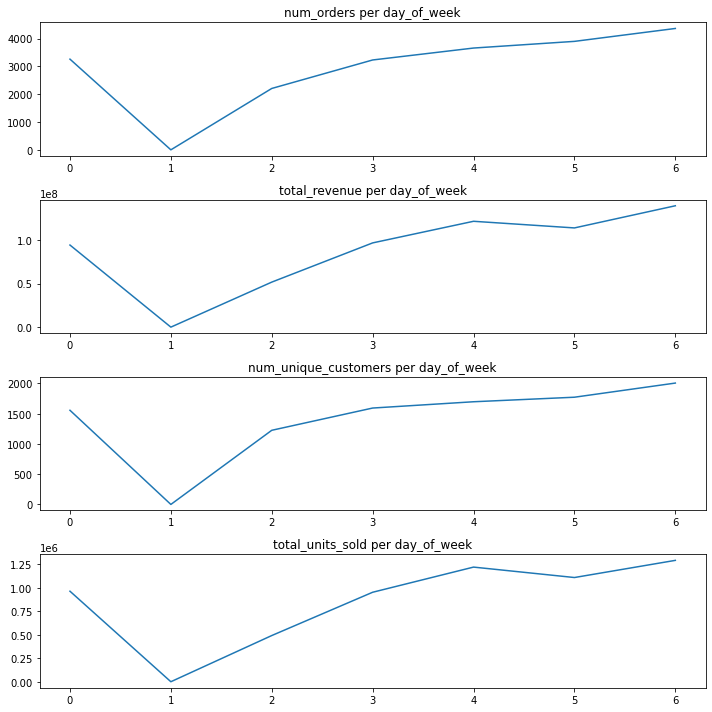

In [175]:
dataframes = [df_dow, df_month, df_hour, df_date, df_country]
df_labels = ['day_of_week', 'month', 'hour', 'invoice_date', 'country']
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (10,10))
for i, var in enumerate (variables):
    ax[i].plot(df_dow['day_of_week'], df_dow[var])
    ax[i].set_title (f'{var} per day_of_week')
    
plt.tight_layout()
plt.show()

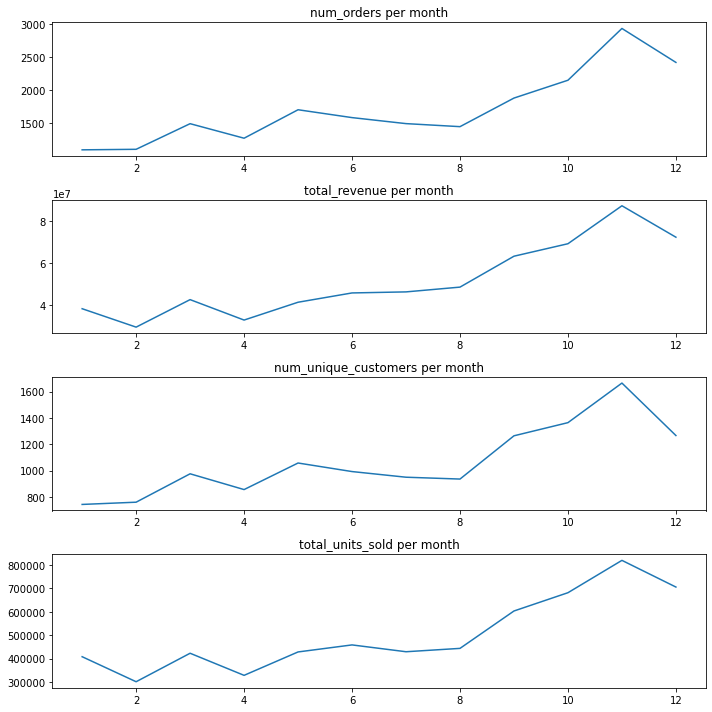

In [176]:
dataframes = [df_dow, df_month, df_hour, df_date, df_country]
df_labels = ['day_of_week', 'month', 'hour', 'invoice_date', 'country']
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (10,10))
for i, var in enumerate (variables):
    ax[i].plot(df_month['month'], df_month[var])
    ax[i].set_title (f'{var} per month')
    
plt.tight_layout()
plt.show()

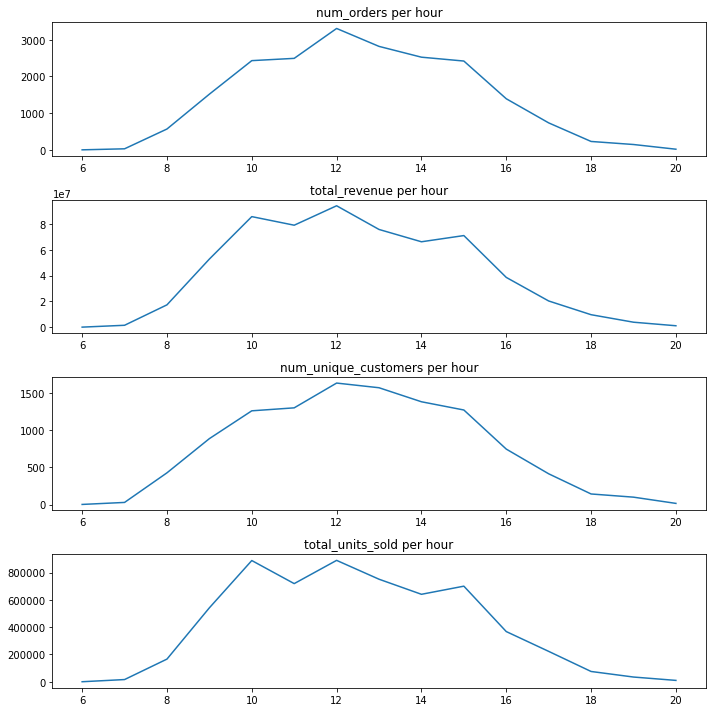

In [177]:
dataframes = [df_dow, df_month, df_hour, df_date, df_country]
df_labels = ['day_of_week', 'month', 'hour', 'invoice_date', 'country']
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (10,10))
for i, var in enumerate (variables):
    ax[i].plot(df_hour['hour'], df_hour[var])
    ax[i].set_title (f'{var} per hour')
    
plt.tight_layout()
plt.show()

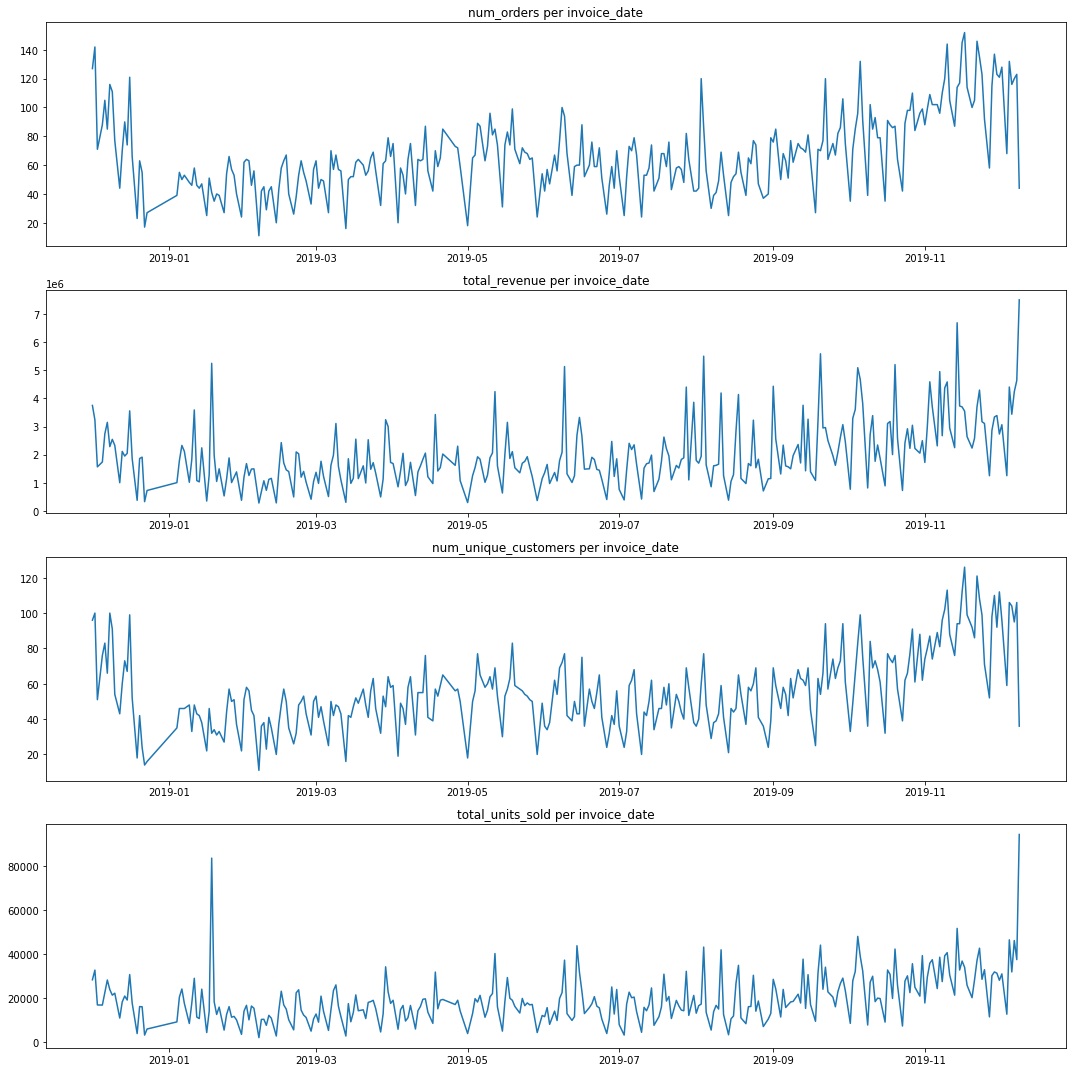

In [171]:
dataframes = [df_dow, df_month, df_hour, df_date, df_country]
df_labels = ['day_of_week', 'month', 'hour', 'invoice_date', 'country']
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (15,15))
for i, var in enumerate (variables):
    ax[i].plot(df_date['invoice_date'], df_date[var])
    ax[i].set_title (f'{var} per invoice_date')
    
plt.tight_layout()
plt.show()



/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_61746/1907644687.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')]['country'], rotation = 90)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_61746/1907644687.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')]['country'], rotation = 90)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_61746/1907644687.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')]['country'], rotation = 90)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_61746/1907644687.py:11: Us

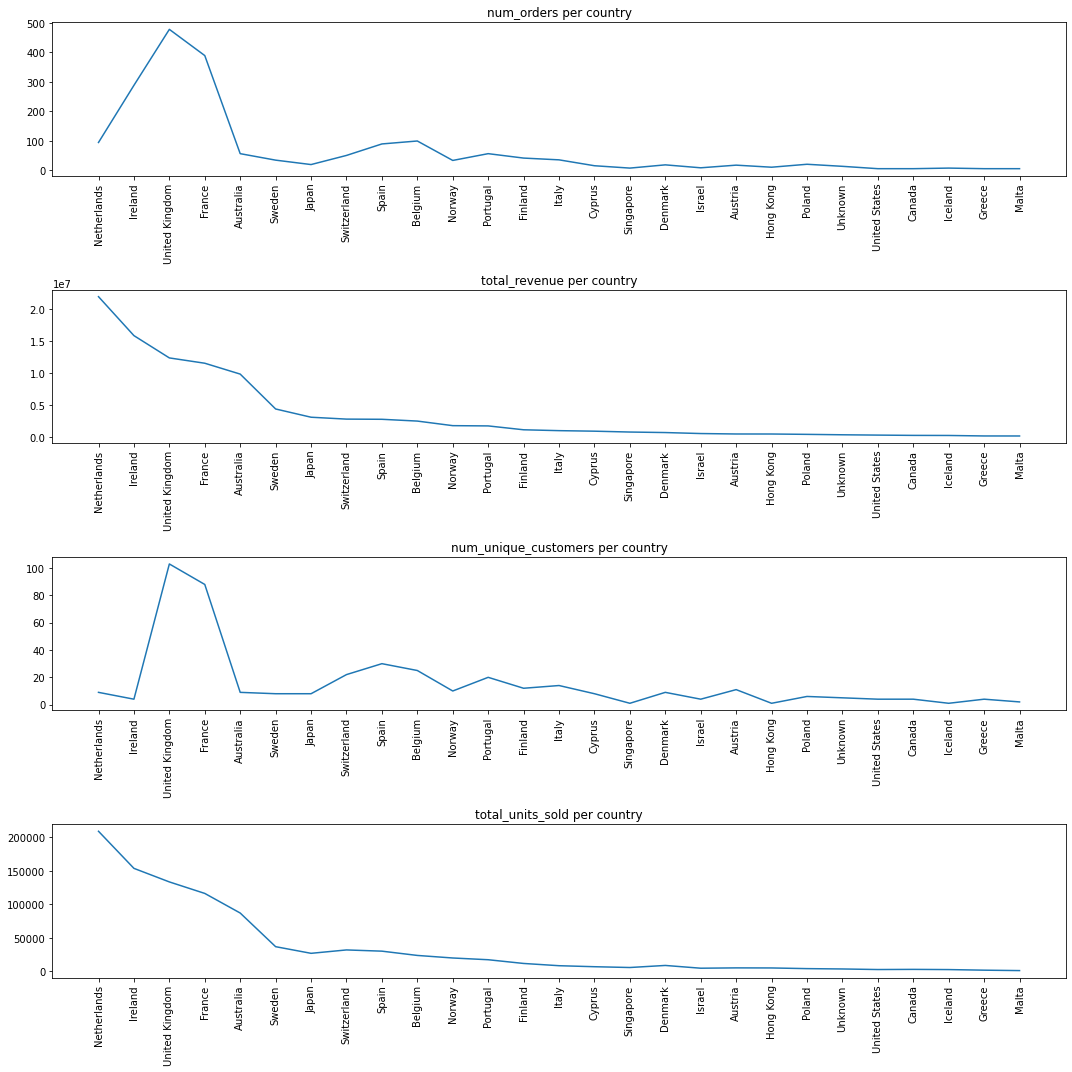

In [183]:
dataframes = [df_dow, df_month, df_hour, df_date, df_country]
df_labels = ['day_of_week', 'month', 'hour', 'invoice_date', 'country']
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (15,15))
for i, var in enumerate (variables):
    ax[i].plot(df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')]['country'], 
                df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')][var])
    ax[i].set_title (f'{var} per country')
    ax[i].set_xticklabels(labels = df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')]['country'], rotation = 90)
    
plt.tight_layout()
plt.show()



<h5> Focus on top 10 countries </h5>

In [303]:
top_10_countries = df_country.sort_values(by = 'total_revenue', ascending = False).head(10)
top_10_countries

,country,num_orders,total_revenue,num_unique_customers,total_units_sold,revenue_per_customer,revenue_per_order
,,,,,,,
0,Germany,18709,5.177474e+08,3922,5062416,1.320111e+05,27673.709838
1,Netherlands,94,2.200264e+07,9,209202,2.444738e+06,234070.655213
2,Ireland,288,1.588787e+07,4,153773,3.971968e+06,55166.222778
3,United Kingdom,478,1.238764e+07,103,133520,1.202683e+05,25915.562615
4,France,389,1.155420e+07,88,116332,1.312977e+05,29702.304524
5,Australia,56,9.848729e+06,9,87033,1.094303e+06,175870.160357
6,Sweden,34,4.373181e+06,8,36760,5.466476e+05,128622.973235
7,Japan,19,3.078620e+06,8,26828,3.848275e+05,162032.643158
8,Switzerland,50,2.782129e+06,22,31893,1.264604e+05,55642.573000


Exclude Germany

In [305]:
top_10_countries.drop(0, axis = 0, inplace = True)
top_10_countries


,country,num_orders,total_revenue,num_unique_customers,total_units_sold,revenue_per_customer,revenue_per_order
,,,,,,,
1,Netherlands,94,22002641.59,9,209202,2.444738e+06,234070.655213
2,Ireland,288,15887872.16,4,153773,3.971968e+06,55166.222778
3,United Kingdom,478,12387638.93,103,133520,1.202683e+05,25915.562615
4,France,389,11554196.46,88,116332,1.312977e+05,29702.304524
5,Australia,56,9848728.98,9,87033,1.094303e+06,175870.160357
6,Sweden,34,4373181.09,8,36760,5.466476e+05,128622.973235
7,Japan,19,3078620.22,8,26828,3.848275e+05,162032.643158
8,Switzerland,50,2782128.65,22,31893,1.264604e+05,55642.573000
9,Spain,89,2754244.31,30,30061,9.180814e+04,30946.565281


/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_61746/2681899901.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_61746/2681899901.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_61746/2681899901.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)


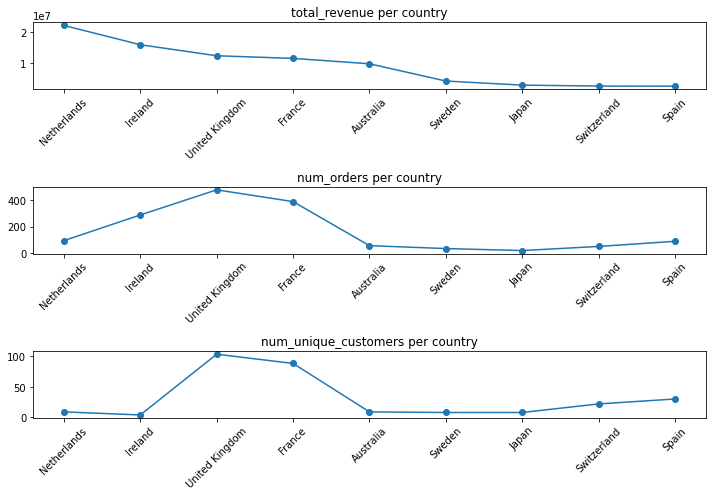

In [319]:
variables = [ 'total_revenue', 'num_orders', 'num_unique_customers']


fig, ax = plt.subplots(3,1, figsize = (10,7))
for i, var in enumerate (variables):
    ax[i].plot(top_10_countries['country'], 
                top_10_countries[var], marker = 'o')
    ax[i].set_title (f'{var} per country')
    ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)
    
plt.tight_layout()
plt.show()

<h3> Revenue per order & revenue per unique customer </h3>

In [317]:
top_10_countries['rev_per_order'] = top_10_countries['total_revenue'] / top_10_countries['num_orders']
top_10_countries['rev_per_customer'] = top_10_countries['total_revenue'] / top_10_countries['num_unique_customers']
top_10_countries


,country,num_orders,total_revenue,num_unique_customers,total_units_sold,revenue_per_customer,revenue_per_order,rev_per_order,rev_per_customer
,,,,,,,,,
1,Netherlands,94,22002641.59,9,209202,2.444738e+06,234070.655213,234070.655213,2.444738e+06
2,Ireland,288,15887872.16,4,153773,3.971968e+06,55166.222778,55166.222778,3.971968e+06
3,United Kingdom,478,12387638.93,103,133520,1.202683e+05,25915.562615,25915.562615,1.202683e+05
4,France,389,11554196.46,88,116332,1.312977e+05,29702.304524,29702.304524,1.312977e+05
5,Australia,56,9848728.98,9,87033,1.094303e+06,175870.160357,175870.160357,1.094303e+06
6,Sweden,34,4373181.09,8,36760,5.466476e+05,128622.973235,128622.973235,5.466476e+05
7,Japan,19,3078620.22,8,26828,3.848275e+05,162032.643158,162032.643158,3.848275e+05
8,Switzerland,50,2782128.65,22,31893,1.264604e+05,55642.573000,55642.573000,1.264604e+05
9,Spain,89,2754244.31,30,30061,9.180814e+04,30946.565281,30946.565281,9.180814e+04


/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_61746/163209811.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_61746/163209811.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)


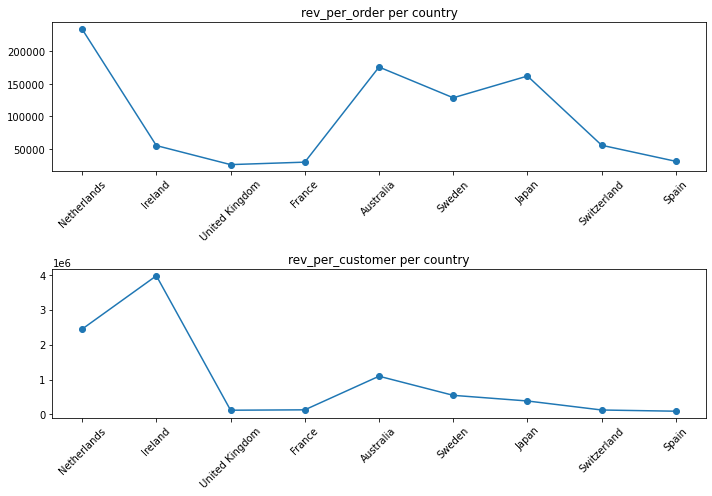

In [318]:
variables = ['rev_per_order', 'rev_per_customer']


fig, ax = plt.subplots(len(variables),1, figsize = (10,7))
for i, var in enumerate (variables):
    ax[i].plot(top_10_countries['country'], 
                top_10_countries[var], marker = 'o')
    ax[i].set_title (f'{var} per country')
    ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)
    
plt.tight_layout()
plt.show()

First graph: which countries have customers making bulk orders? (Netherlands, Australia, Sweden, Japan) <br>
Second graph: which countries have small number of customers making large sum of purchases? (Netherlands, Ireland, Australia)

<h3> Days in 2019 with unusual peaks and troughs in total_revenue </h3>

In [270]:
df_date.head()

,invoice_date,num_orders,total_revenue,num_unique_customers,total_units_sold,total_revenue_rolling_mean,total_revenue_minus_mean
,,,,,,,
0,2018-12-01,127,3752031.65,96,28360,NaN,NaN
1,2018-12-02,142,3234897.52,100,32749,2.850544e+06,384353.926667
2,2018-12-03,71,1564701.61,51,16945,2.179020e+06,-614318.083333
3,2018-12-05,88,1737459.95,76,16886,2.014446e+06,-276986.526667
4,2018-12-06,105,2741177.87,83,22700,2.542569e+06,198608.880000


To locate unusual peaks: <br>
Add column for the "rolling mean" and column for "total revenue - rolling mean"

In [287]:
df_date ['total_revenue_rolling_mean'] = df_date['total_revenue'].rolling(5, center= True).mean()       # mean of current date + previous date + following date
df_date['total_revenue_minus_mean'] = df_date ['total_revenue'] - df_date ['total_revenue_rolling_mean'] # current value - mean value

In [288]:
# Convert invoice_date column to datetime format
df_date['invoice_date'] = pd.to_datetime(df_date['invoice_date'])

Select top 20 rows

In [289]:
high_rev_dates = df_date[df_date['invoice_date'].dt.year == 2019].sort_values(by = 'total_revenue_minus_mean', ascending = False).head(20)[['invoice_date', 'total_revenue']]

Select bottom 20 rows

In [290]:
low_rev_dates = df_date[df_date['invoice_date'].dt.year == 2019].sort_values(by = 'total_revenue_minus_mean', ascending = True).head(20)[['invoice_date', 'total_revenue']]

In [297]:
weekends_2019 = df_date [(df_date['invoice_date'].dt.day_name() == 'Saturday') | (df_date['invoice_date'].dt.day_name() == 'Sunday')]
weekends_2019 = weekends_2019[weekends_2019['invoice_date'].dt.year == 2019]
weekends_2019 = weekends_2019 [['invoice_date','total_revenue']]

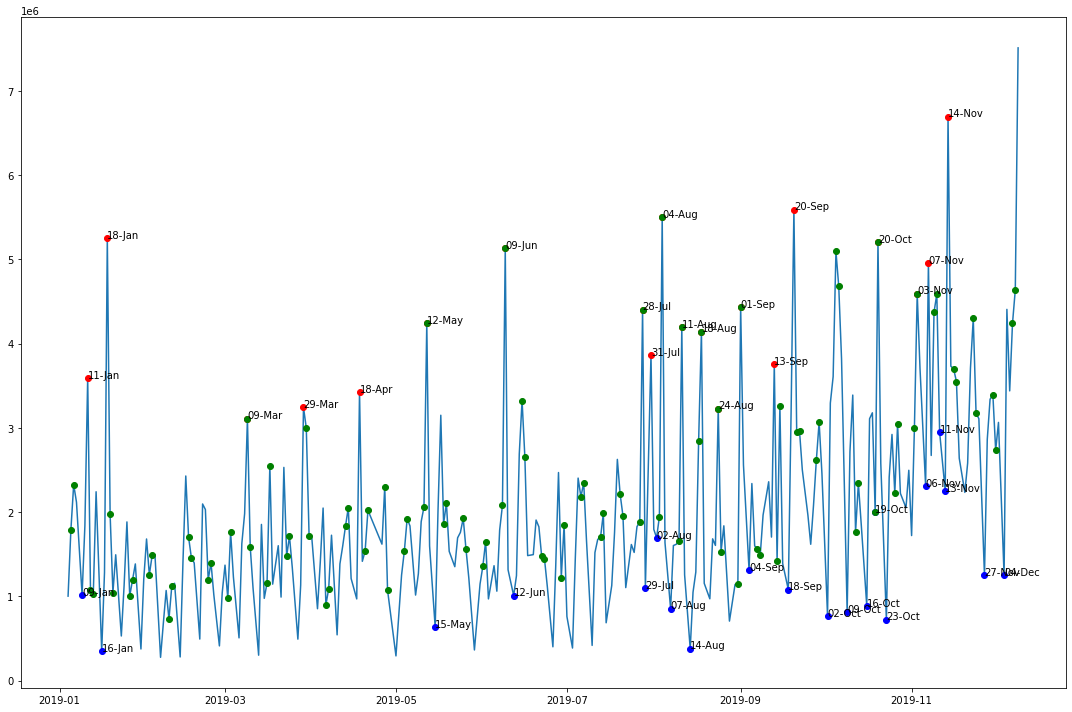

In [299]:
x = high_rev_dates ['invoice_date']
y = high_rev_dates ['total_revenue']

a = low_rev_dates ['invoice_date']
b = low_rev_dates ['total_revenue']

m = weekends_2019['invoice_date']
n = weekends_2019['total_revenue']


df_date_2019 = df_date [df_date['invoice_date'].dt.year == 2019]

plt.figure(figsize = (15,10))
plt.plot (df_date_2019['invoice_date'], df_date_2019['total_revenue'])
for xy in zip (x,y):
    plt.plot(xy[0], xy[1], color = 'r', marker = 'o')
    plt.annotate(f'{xy[0].strftime("%d-%b")}', xy = xy)

for ab in zip (a,b):
    plt.plot(ab[0], ab[1], color = 'b', marker = 'o')
    plt.annotate(f'{ab[0].strftime("%d-%b")}', xy = ab)

for mn in zip (m,n):
    plt.plot(mn[0], mn[1], color = 'g', marker = 'o')
    #plt.annotate(f'{mn[0].strftime("%d-%b")}', xy = mn)

plt.tight_layout()
plt.show()

Green dots with no date: weekends <br>
Green dots with no date: weekends + unusually high sales

Notice that regardless of the "red dot" locations, most of the local maxima have a green dot